In [1]:
import tensorflow as tf
import matplotlib.pyplot as plt
import uncertainty_wizard as uwiz
# uwiz.models.ensemble_utils.DynamicGpuGrowthContextManager.enable_dynamic_gpu_growth()

2024-02-02 18:27:09.649018: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-02-02 18:27:15.023946: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdirectml.d6f03b303ac3c4f2eeb8ca631688c9757b361310.so
2024-02-02 18:27:15.024033: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libdxcore.so
2024-02-02 18:27:15.026470: I tensorflow/c/logging.cc:34] Successfully opened dynamic library libd3d12.so
2024-02-02 18:27:15.661198: I tensorflow/c/logging.cc:34] DirectML device enumeration: found 1 compatible adapters.


Training data:        (60000, 28, 28)
Training solution:    (60000,)
Test data:            (10000, 28, 28)
Test solution:        (10000,)


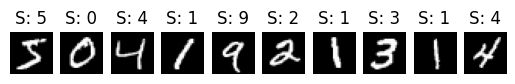

Training data:        (60000, 28, 28, 1)
Training solution:    (60000, 10)
Test data:            (10000, 28, 28, 1)
Test solution:        (10000, 10)


In [2]:


(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

print("Training data:       ", x_train.shape)
print("Training solution:   ", y_train.shape)
print("Test data:           ", x_test.shape)
print("Test solution:       ", y_test.shape)

fig, axes = plt.subplots(1, 10)
for i in range(10):
    axes[i].imshow(x_train[i], cmap='gray', vmin=0, vmax=255)
    axes[i].set_title(f"S: {y_train[i]}")
    axes[i].axis('off')
plt.show()

x_train = (x_train.astype('float32') / 255).reshape(x_train.shape[0], 28, 28, 1)
y_train = tf.keras.utils.to_categorical(y_train, num_classes=10)
x_test = (x_test.astype('float32') / 255).reshape(x_test.shape[0], 28, 28, 1)
y_test = tf.keras.utils.to_categorical(y_test, num_classes=10)      #??????????

print("Training data:       ", x_train.shape)
print("Training solution:   ", y_train.shape)
print("Test data:           ", x_test.shape)
print("Test solution:       ", y_test.shape)


* functions (imshow) from Matplotlib Documentation. REF: https://matplotlib.org/stable/api/_as_gen/matplotlib.pyplot.imshow.html

* Adding a new dimension(1) for train and test, because the color is just black or white and no extra color.
* Divide with 255 so we can change the (0 - 255) to (0 or 1)

Epoch 1/20


2024-02-02 18:27:59.044060: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-02 18:27:59.123020: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 18:27:59.123119: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17825 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


11/11 [==============================] - 2s 157ms/step - loss: 2.3004 - accuracy: 0.1062 - val_loss: 2.2988 - val_accuracy: 0.1002
Epoch 2/20
 1/11 [=>............................] - ETA: 0s - loss: 2.3011 - accuracy: 0.1060

2024-02-02 18:28:00.753208: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.
2024-02-02 18:28:00.787489: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 18:28:00.787551: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17825 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


11/11 [==============================] - 1s 97ms/step - loss: 2.2992 - accuracy: 0.1080 - val_loss: 2.2969 - val_accuracy: 0.1037
Epoch 3/20
11/11 [==============================] - 1s 88ms/step - loss: 2.2978 - accuracy: 0.1117 - val_loss: 2.2950 - val_accuracy: 0.1077
Epoch 4/20
11/11 [==============================] - 1s 90ms/step - loss: 2.2962 - accuracy: 0.1155 - val_loss: 2.2930 - val_accuracy: 0.1138
Epoch 5/20
11/11 [==============================] - 1s 89ms/step - loss: 2.2949 - accuracy: 0.1172 - val_loss: 2.2911 - val_accuracy: 0.1210
Epoch 6/20
11/11 [==============================] - 1s 88ms/step - loss: 2.2930 - accuracy: 0.1220 - val_loss: 2.2891 - val_accuracy: 0.1277
Epoch 7/20
11/11 [==============================] - 1s 91ms/step - loss: 2.2910 - accuracy: 0.1259 - val_loss: 2.2872 - val_accuracy: 0.1342
Epoch 8/20
11/11 [==============================] - 1s 88ms/step - loss: 2.2898 - accuracy: 0.1291 - val_loss: 2.2852 - val_accuracy: 0.1398
Epoch 9/20
11/11 [======

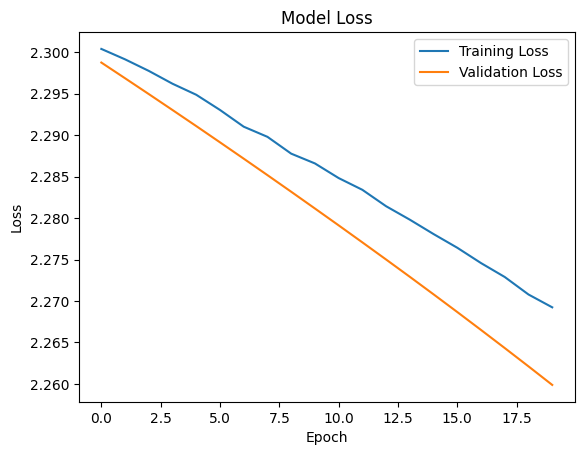

In [4]:

# model = tf.keras.models.Sequential()
model = uwiz.models.StochasticSequential()

# model.add(tf.keras.layers.Conv2D(filters, kernel_size=(size), activation='methods', input_shape=(shape info)))
model.add(tf.keras.layers.Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(28, 28, 1)))
model.add(tf.keras.layers.Conv2D(64, (3, 3), activation='relu'))

# model.add(tf.keras.layers.MaxPooling2D(pool_size=(max pooling height and width)))
model.add(tf.keras.layers.MaxPooling2D(pool_size=(2, 2)))

# model.add(tf.keras.layers.Dropout(fraction %)) 
model.add(tf.keras.layers.Dropout(0.5))

model.add(tf.keras.layers.Flatten())

# model.add(tf.keras.layers.Dense(digits, activation='methods'))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dense(10, activation='softmax'))

model.compile(loss=tf.keras.losses.categorical_crossentropy,
              optimizer=tf.keras.optimizers.Adadelta(),
              metrics=['accuracy'])

model_info = model.fit(x_train, y_train, validation_split=0.1, batch_size=5000, epochs=20,
                  verbose=1, callbacks=[tf.keras.callbacks.EarlyStopping(patience=2)])

print(model.inner.summary())


plt.plot(model_info.history['loss'], label='Training Loss')
plt.plot(model_info.history['val_loss'], label='Validation Loss')

plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

Uncertainty Wizard
* Uncertainty Wizard sequential has same function as Keras sequential, but is specially made to handle uncertainty.

epochs

Layers Conv2D
* Convolutional layer that use the number of filter with different sizes to find different value from edges, corners and so on.

Layers MaxPooling2D
* Make the data more robust by splitting the 2d-block data and only keeping the highest value from each part.

Layers Dropout
* Prevent overfitting by having 50% droprate of unit during the traning of the model. It will help out with learn redundant learning and make the progress more robust.

Layers Flatten
* Flatten it out from 2D array to a 1D array.
* Doesn't affect batch size.

Layer Dense


  59/5000 [..............................] - ETA: 13s

2024-02-02 18:28:26.746134: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


5000/5000 [==============================] - 12s 2ms/step


2024-02-02 18:28:38.831040: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 18:28:38.831099: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17825 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)
2024-02-02 18:28:40.588048: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 18:28:40.588112: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17825 MB memory) -> physical PluggableDevice (device: 0, name: 

157/157 [==============================] - 1s 3ms/step


2024-02-02 18:28:41.587255: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-02-02 18:28:41.587312: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 17825 MB memory) -> physical PluggableDevice (device: 0, name: DML, pci bus id: <undefined>)


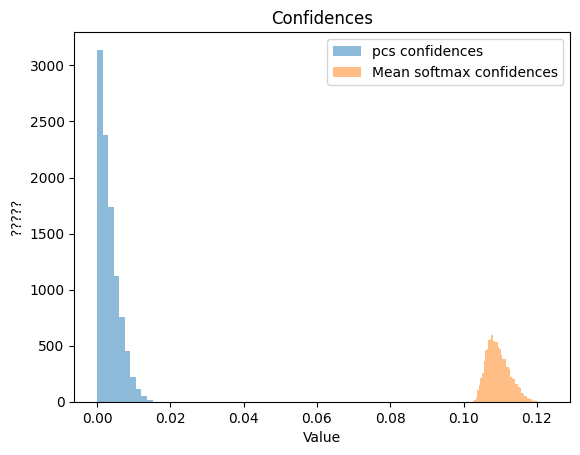

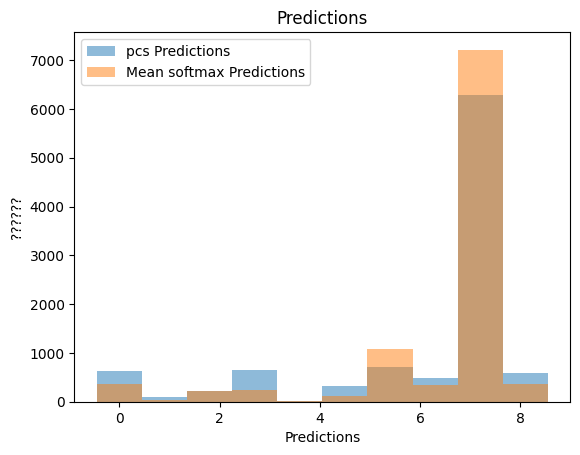

In [5]:
quantifiers = ['pcs', 'mean_softmax']
results = model.predict_quantified(x_test,
                                   quantifier=quantifiers,
                                   batch_size=64,
                                   sample_size=32,
                                   verbose=1)


pcs_predictions = results[0][0]
pcs_confidences = results[0][1]
mean_softmax_predictions = results[1][0]
mean_softmax_confidences = results[1][1]

plt.hist(pcs_confidences, alpha=0.5, label='pcs confidences')
plt.hist(mean_softmax_confidences, bins=50, alpha=0.5, label='Mean softmax confidences')
plt.xlabel('Value')
plt.ylabel('?????')
plt.title('Confidences')
plt.legend()
plt.show()

plt.hist(pcs_predictions, alpha=0.5, label='pcs Predictions', align='left')
plt.hist(mean_softmax_predictions, alpha=0.5, label='Mean softmax Predictions', align='left')
plt.xlabel('Predictions')
plt.ylabel('??????')
plt.title('Predictions')
plt.legend()
plt.show()